# Modelling spreading of enfectious diseases
Very much an experiment inspired by https://triplebyte.com/blog/modeling-infectious-diseases   

In this model the model is divided into different age groups. 
The model runs, but is not developed. 

The model is specified very parsimonious and exploded to a full model specification by the model manipulation functions:
mp.doable, mp.explode and mp.lagarray_unroll. 

In [1]:
import pandas as pd

from modelclass import model
import modelclass as mc
import modelmanipulation as mp 
model.modelflow_auto()

In [2]:
def dist_erlang(length,a=1,rate=1):
    aa=int(a)
    weights_before =  np.array([erlang.cdf(x+1., aa,rate)-erlang.cdf(x, aa,rate) for x in range(length)])
    weights = weights_before/weights_before.sum()
    sweights =pd.Series(weights)
    return sweights

def lag_erlang(values,a=1,rate=1):
    weights=dist_erlang(len(values),a,rate)
    weighted = (values*weights)
    print(weighted)
    return weighted.sum()


def lag_manual(values,weights,debug=0):
    weights_s = pd.Series(weights)
    weights_normalized = weights_s/weights_s.sum()
    values_s  = pd.Series(values)
    weighted  = (values_s*weights_normalized).fillna(0)
    result = weighted.sum()
    if int(debug):
        weights_org = pd.Series(weights)
        temp = pd.concat([weights_s, weights_normalized,values_s,weighted],axis=1)
        temp.columns = ['weights_org','weights normallized','Values','weighted values']
        time = pd.Series([int(i) for i in temp.index])
        average_lag = (pd.Series(time)*weights_normalized).fillna(0).sum()
        print(temp)
        print(f'Result       {result:15.5f}')
        print(f'Average lag  {average_lag:15.5f}')
        # print(time)
    return result 


In [3]:
DAYS = 100
# Specify Model 
rcorona = '''\

list age_list = age : 0_9 10_19 20_29 30_39 40_49 50_59 60_69 70_79  80_120

<sum=all>  new_exposed__{age}       = infection_rate__{age} * susceptible__{age} + exo_exposed__{age}
<sum=all>  new_infectious__{age}    = lag_manual(lag_array(4, new_exposed__{age}),(0,0,80,20))
            
<sum=all>  new_recovered__{age}     =  0.6 *lag_manual(lag_array(10, new_infectious__{age}),(0,0,0,0,0,80,20))
<sum=all>  new_dead__{age}          =  0.4 *lag_manual(lag_array(10, new_infectious__{age}),(0,0,0,0,0,80,20))
           
<sum=all>  diff(infectious__{age})  = new_infectious__{age} - new_recovered__{age} - new_dead__{age}
            
<sum=all>  diff(susceptible__{age}) = -new_exposed__{age}  
<sum=all>  diff(dead__{age})        = new_dead__{age}
<sum=all>  diff(recovered__{age})   = new_recovered__{age}
<sum=all>  diff(population__{age})  = -new_dead__{age}

infection_rate__{age}          = rate_contact__{age} * probability_transmision__{age} * infectious__{age}(-1) / population__{age}(-1)

infectious_growth__all = 100* (infectious__all/infectious__all(-1)-1)
dead_growth__all = 100* (dead__all/dead__all(-1)-1)
'''

# create a model instance 
f0corona = mp.doable(rcorona)
f1corona = mp.explode(f0corona)
fcorona = mp.lagarray_unroll(f1corona,funks=[lag_manual])
mcorona = model(fcorona,funks=[lag_manual])
# mcorona.drawmodel(lag=1,size=(2,2))

In [4]:
print(f0corona)   # to look at the phases the model specification undergoes try printing f1corona and fcorona

list age_list = age : 0_9 10_19 20_29 30_39 40_49 50_59 60_69 70_79  80_120  
Do age_list  
  <sum=all>  new_exposed__{age}       = infection_rate__{age} * susceptible__{age} + exo_exposed__{age}  
Enddo  

NEW_EXPOSED__all = sum(age_list,NEW_EXPOSED__{AGE})  

Do age_list  
  <sum=all>  new_infectious__{age}    = lag_manual(lag_array(4, new_exposed__{age}),(0,0,80,20))  
Enddo  

NEW_INFECTIOUS__all = sum(age_list,NEW_INFECTIOUS__{AGE})  

Do age_list  
  <sum=all>  new_recovered__{age}     =  0.6 *lag_manual(lag_array(10, new_infectious__{age}),(0,0,0,0,0,80,20))  
Enddo  

NEW_RECOVERED__all = sum(age_list,NEW_RECOVERED__{AGE})  

Do age_list  
  <sum=all>  new_dead__{age}          =  0.4 *lag_manual(lag_array(10, new_infectious__{age}),(0,0,0,0,0,80,20))  
Enddo  

NEW_DEAD__all = sum(age_list,NEW_DEAD__{AGE})  

Do age_list  
  <sum=all>  diff(infectious__{age})  = new_infectious__{age} - new_recovered__{age} - new_dead__{age}  
Enddo  

INFECTIOUS__all = sum(age_list,INFECTIOUS__

# Define some mock data

In [5]:
basedf = pd.DataFrame(index=range(DAYS))    # make an empty dataframe with DAYS rows
grunddf = mc.insertModelVar(basedf,mcorona) # fill dataframe with zeros 
for age in mcorona.lister['AGE_LIST']['AGE']:
    grunddf.loc[:,f'POPULATION__{age}']= 1000000
    grunddf[f'SUSCEPTIBLE__{age}'] = grunddf[f'POPULATION__{age}']
    grunddf.loc[12,f'EXO_EXPOSED__{age}']= 100

    grunddf.loc[:,f'RATE_CONTACT__{age}'] = 10
    grunddf.loc[:,f'PROBABILITY_TRANSMISION__{age}'] = 0.1

# Run the model 

In [6]:
res1 = mcorona(grunddf,max_iterations=40,first_test=4,silent=1,absconv=2,relconv=0.000000001,init=True)

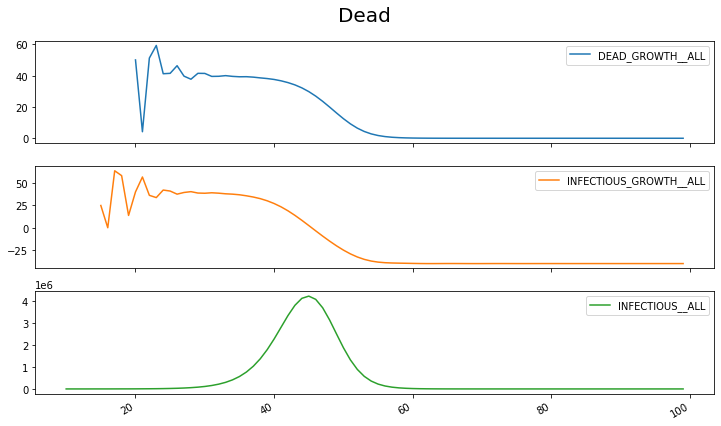

In [7]:
mcorona['*growth__all infectious__all'].plot(colrow=1,sharey=0,ppos=0,title='Dead',splitchar='');

In [8]:
mcorona['infectious_growth__all infectious__all'].df.style.format('{0:,.1f}')

,INFECTIOUS_GROWTH__ALL,INFECTIOUS__ALL
10,nan,0.0
11,nan,0.0
12,nan,0.0
13,nan,0.0
14,inf,720.0
15,25.0,900.0
16,0.0,900.0
17,64.0,"1,475.9"
18,58.5,"2,339.7"
19,13.8,"2,663.3"


In [9]:
basedf = pd.DataFrame(index=range(DAYS))    # make an empty dataframe with DAYS rows
grunddf = mc.insertModelVar(basedf,mcorona) # fill dataframe with zeros 
grunddf.loc[:,'POPULATION']= 1000000
grunddf['SUSCEPTIBLE'] = grunddf['POPULATION']
grunddf.loc[5,'EXO_EXPOSED']= 100

res1 = mcorona(grunddf,max_iterations=40,first_test=2,silent=1)

In [10]:
cow = mcorona.inputwidget(basedf=grunddf,modelopt={'silent':1},
                  slidedef = {
                     'Number of infected t=1'     :{'var' : 'EXO_EXPOSED','min' : 0.0, 'max' : 1000, 'value' : 0.0,'step':10,'op':'+impulse'},
                     'Rate of contact'            :{'var' : 'RATE_CONTACT','min' : 0.0, 'max' : 100, 'value' : 1,'step':1},
                     'Probability of transmission':{'var' : 'PROBABILITY_TRANSMISION','min' : 0.0, 'max' : 1.0, 'value' : 0.2},
                     'Daily incuberation rate'    :{'var' : 'INCUBATION_RATE','min' : 0.0, 'max' : 1.0, 'value' : 0.3},
                     'Daily death rate'           :{'var' : 'DEAD_RATE','min' : 0.0, 'max' : 1.0, 'value' : 0.2},
                     'Daily recovery rate'        :{'var' : 'RECOVERY_RATE','min' : 0.0, 'max' : 1.0, 'value' : 0.2}
                             },
                 varpat='#endo')

display(cow)